In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score, f1_score,confusion_matrix
from xgboost.sklearn import XGBClassifier
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import plot_importance, to_graphviz
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report



In [2]:
url = 'https://drive.google.com/uc?export=download&confirm=6gh6&id=1VNpyNkGxHdskfdTNRSjjyNa5qC9u0JyV'
data = pd.read_csv(url)
data.shape

(6362620, 11)

# Analysis

In [4]:
print(data.head())
print(data.info())
print(data.describe())

   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 co

In [5]:
# Check for null values
data.isnull().values.any()

False

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [7]:
legit = len(data[data.isFraud == 0])
fraud = len(data[data.isFraud == 1])
legit_percent = (legit / (fraud + legit)) * 100
fraud_percent = (fraud / (fraud + legit)) * 100

print("Number of Legit transactions: ", legit)
print("Number of Fraud transactions: ", fraud)
print("Percentage of Legit transactions: {:.4f} %".format(legit_percent))
print("Percentage of Fraud transactions: {:.4f} %".format(fraud_percent))

Number of Legit transactions:  6354407
Number of Fraud transactions:  8213
Percentage of Legit transactions: 99.8709 %
Percentage of Fraud transactions: 0.1291 %


These results show that the data is highly unbalanced, with 99.87% of legitimate transactions and 0.13% of fraudulent transactions. Decision trees and random forests are effective methods for imbalanced data.

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64


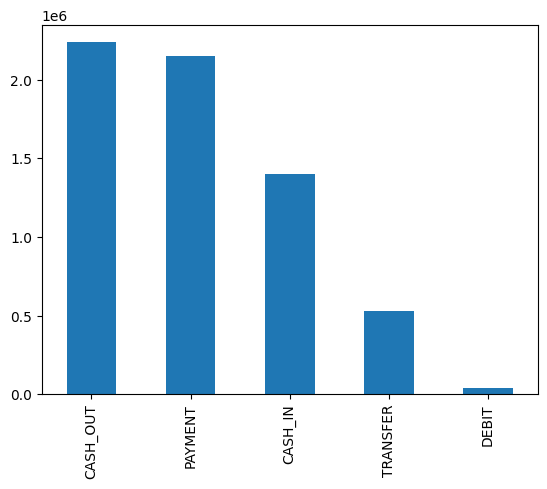

In [10]:
# Count number of data point in each type of transaction
print(data.type.value_counts())
data.type.value_counts().plot(kind='bar')
plt.show()

In [11]:
# Investigate variable "isFlaggedFraud"
pd.crosstab(data.isFraud,data.isFlaggedFraud)

isFlaggedFraud,0,1
isFraud,,
0,6354407,0
1,8197,16


In [12]:
#Groupby type
data.groupby('type')['isFraud','isFlaggedFraud'].sum()

<ipython-input-12-0250a5b2edc4>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data.groupby('type')['isFraud','isFlaggedFraud'].sum()


,isFraud,isFlaggedFraud
type,,
CASH_IN,0,0
CASH_OUT,4116,0
DEBIT,0,0
PAYMENT,0,0
TRANSFER,4097,16


Fraud only occurs in two types of transactions: TRANSFER and CASH_OUT.

The total number of fraudulent TRANSFERS is 4097.

The total number of fraudulent CASH_OUTs is 4116.

The type of transaction for which isFlaggedFraud is set: TRANSFER


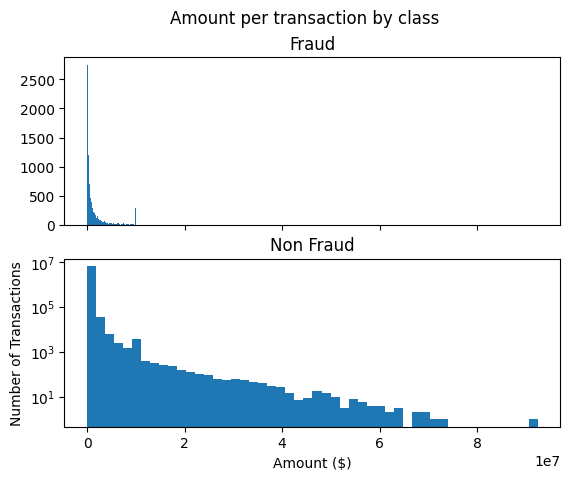

In [19]:
# Amount Vs number of transaction
fraud = data[data['isFraud']==1]
normal = data[data['isFraud']==0]
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')
bins = 50
ax1.hist(fraud.amount, bins = bins)
ax1.set_title('Fraud')
ax2.hist(normal.amount, bins = bins)
ax2.set_title('Non Fraud')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.yscale('log')
plt.show();

Less number of transactions in fraud data compared to non-fraud data


#Data pre-processing

In [20]:
#creating a copy of original dataset to train and test models

new_data=data.copy()
new_data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


Label Encoding

In [21]:
# Checking how many attributes are dtype: object
objList = new_data.select_dtypes(include = "object").columns
print (objList)

Index(['type', 'nameOrig', 'nameDest'], dtype='object')


Object datatype has three attributes. In order to test multicolinearity, we must label encode them.

In [23]:
#Label Encoding for object to numeric conversion
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for feat in objList:
    new_data[feat] = le.fit_transform(new_data[feat].astype(str))

print (new_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            int64  
 2   amount          float64
 3   nameOrig        int64  
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        int64  
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(6)
memory usage: 534.0 MB
None


In [24]:
new_data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,3,9839.64,757869,170136.0,160296.36,1662094,0.0,0.0,0,0
1,1,3,1864.28,2188998,21249.0,19384.72,1733924,0.0,0.0,0,0
2,1,4,181.00,1002156,181.0,0.00,439685,0.0,0.0,1,0
3,1,1,181.00,5828262,181.0,0.00,391696,21182.0,0.0,1,0
4,1,3,11668.14,3445981,41554.0,29885.86,828919,0.0,0.0,0,0


In [25]:
# Import library for VIF (variance Inflation Factor)

from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(df):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

    return(vif)

calc_vif(new_data)

,variables,VIF
0,step,2.791610
1,type,4.467405
2,amount,4.149312
3,nameOrig,2.764234
4,oldbalanceOrg,576.803777
5,newbalanceOrig,582.709128
6,nameDest,3.300975
7,oldbalanceDest,73.349937
8,newbalanceDest,85.005614
9,isFraud,1.195305


We can see that oldbalanceOrg and newbalanceOrig have excessively high VIF, indicating that they are highly correlated. The same goes for oldbalanceDest and newbalanceDest. NameDest is also linked to nameOrig.

Thus, combine these collinear attributes and discard the individual ones.


In [26]:
new_data['Actual_amount_orig'] = new_data.apply(lambda x: x['oldbalanceOrg'] - x['newbalanceOrig'],axis=1)
new_data['Actual_amount_dest'] = new_data.apply(lambda x: x['oldbalanceDest'] - x['newbalanceDest'],axis=1)
new_data['TransactionPath'] = new_data.apply(lambda x: x['nameOrig'] + x['nameDest'],axis=1)

#Dropping columns
new_data = new_data.drop(['oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','step','nameOrig','nameDest'],axis=1)

calc_vif(new_data)

,variables,VIF
0,type,2.687803
1,amount,3.818902
2,isFraud,1.184479
3,isFlaggedFraud,1.002546
4,Actual_amount_orig,1.307910
5,Actual_amount_dest,3.754335
6,TransactionPath,2.677167


<Axes: >

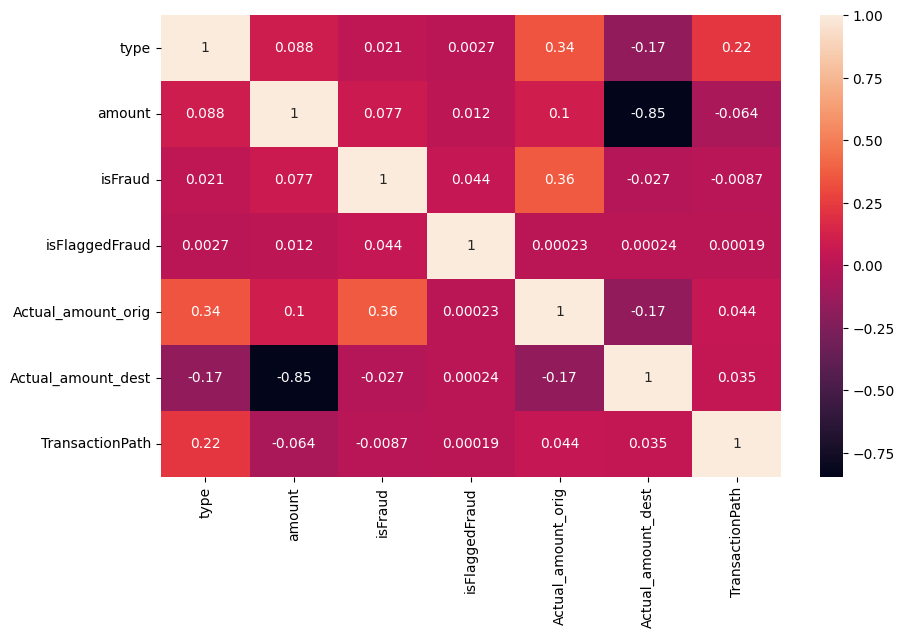

In [27]:
corr=new_data.corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr,annot=True)

How did you select variables to be included in the model?
The VIF values and correlation heatmap are used. We simply need to see if there are any two attributes that are highly correlated with each other, and then discard the one that is less correlated with the isFraud Attribute.


#Model Building

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import itertools
from collections import Counter
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

Normalizing

In [29]:
scaler = StandardScaler()
new_data["NormalizedAmount"] = scaler.fit_transform(new_data["amount"].values.reshape(-1, 1))
new_data.drop(["amount"], inplace= True, axis= 1)

Y = new_data["isFraud"]
X = new_data.drop(["isFraud"], axis= 1)

I did not normalize the complete dataset because it may lead to decrease in accuracy of model.

Train-test Split

In [30]:
# Split the data
(X_train, X_test, Y_train, Y_test) = train_test_split(X, Y, test_size= 0.3, random_state= 42)

print("Shape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_test.shape)

Shape of X_train:  (4453834, 6)
Shape of X_test:  (1908786, 6)


#Training the Model

In [32]:
# DECISION TREE

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)

Y_pred_dt = decision_tree.predict(X_test)
decision_tree_score = decision_tree.score(X_test, Y_test) * 100

In [33]:
# RANDOM FOREST

random_forest = RandomForestClassifier(n_estimators= 100)
random_forest.fit(X_train, Y_train)

Y_pred_rf = random_forest.predict(X_test)
random_forest_score = random_forest.score(X_test, Y_test) * 100

In [34]:
# XGBoost Classifier
weights = (Y == 0).sum() / (1.0 * (Y == 1).sum()) # giving class weight
clf = XGBClassifier( scale_pos_weight = weights, n_jobs = 4, random_state=42)
clf.fit(X_train, Y_train)

Y_pred_xg = clf.predict(X_test)
xgboost_score = clf.score(X_test,Y_test)*100
# model_result(clf,X_test,y_test)

#Evaluation

In [35]:
# Print scores of our classifiers

print("Decision Tree Score: ", decision_tree_score)
print("Random Forest Score: ", random_forest_score)
print("XGBoost Classifier Score: ", xgboost_score)

Decision Tree Score:  99.92377353983107
Random Forest Score:  99.95887438403257
XGBoost Classifier Score:  97.57191219969133


In [36]:
# key terms of Confusion Matrix - DT

print("TP,FP,TN,FN - Decision Tree")
tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred_dt).ravel()
print(f'True Positives: {tp}')
print(f'False Positives: {fp}')
print(f'True Negatives: {tn}')
print(f'False Negatives: {fn}')

print("----------------------------------------------------------------------------------------")

# key terms of Confusion Matrix - RF

print("TP,FP,TN,FN - Random Forest")
tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred_rf).ravel()
print(f'True Positives: {tp}')
print(f'False Positives: {fp}')
print(f'True Negatives: {tn}')
print(f'False Negatives: {fn}')


print("----------------------------------------------------------------------------------------")

# key terms of Confusion Matrix - XG

print("TP,FP,TN,FN - XGBoost Classifier")
tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred_xg).ravel()
print(f'True Positives: {tp}')
print(f'False Positives: {fp}')
print(f'True Negatives: {tn}')
print(f'False Negatives: {fn}')

TP,FP,TN,FN - Decision Tree
True Positives: 1716
False Positives: 736
True Negatives: 1905615
False Negatives: 719
----------------------------------------------------------------------------------------
TP,FP,TN,FN - Random Forest
True Positives: 1713
False Positives: 63
True Negatives: 1906288
False Negatives: 722
----------------------------------------------------------------------------------------
TP,FP,TN,FN - XGBoost Classifier
True Positives: 2254
False Positives: 46166
True Negatives: 1860185
False Negatives: 181


TP(Decision Tree) ~ TP(Random Forest) > TN(XGBoost Classifier) - Even though XGBoost outperforms here, we should consider other scores.

FB(XGBoost Classifier) >> FP(Decision Tree) >> FP(Random Forest) - Random Forest has an edge.

TN(XGBoost Classifier) < TN(Decision Tree) < TN(Random Forest) - Random Forest is better here too

FN(XGBoost Classifier) > FN(Decision Tree) ~ FN(Random Forest) - XgBoost performs worst here!


Hence Random Forest is obvious choice.

In [37]:
# confusion matrix - DT

confusion_matrix_dt = confusion_matrix(Y_test, Y_pred_dt.round())
print("Confusion Matrix - Decision Tree")
print(confusion_matrix_dt,)

print("----------------------------------------------------------------------------------------")

# confusion matrix - RF

confusion_matrix_rf = confusion_matrix(Y_test, Y_pred_rf.round())
print("Confusion Matrix - Random Forest")
print(confusion_matrix_rf)

print("----------------------------------------------------------------------------------------")

# confusion matrix - XG

confusion_matrix_xg = confusion_matrix(Y_test, Y_pred_xg.round())
print("Confusion Matrix - XGBoost Classifier")
print(confusion_matrix_xg)

Confusion Matrix - Decision Tree
[[1905615     736]
 [    719    1716]]
----------------------------------------------------------------------------------------
Confusion Matrix - Random Forest
[[1906288      63]
 [    722    1713]]
----------------------------------------------------------------------------------------
Confusion Matrix - XGBoost Classifier
[[1860185   46166]
 [    181    2254]]


In [38]:
# classification report - DT

classification_report_dt = classification_report(Y_test, Y_pred_dt)
print("Classification Report - Decision Tree")
print(classification_report_dt)

print("----------------------------------------------------------------------------------------")

# classification report - RF

classification_report_rf = classification_report(Y_test, Y_pred_rf)
print("Classification Report - Random Forest")
print(classification_report_rf)

print("----------------------------------------------------------------------------------------")

# classification report - XG

classification_report_xg = classification_report(Y_test, Y_pred_xg)
print("Classification Report - XGBoost Classifier")
print(classification_report_xg)

Classification Report - Decision Tree
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       0.70      0.70      0.70      2435

    accuracy                           1.00   1908786
   macro avg       0.85      0.85      0.85   1908786
weighted avg       1.00      1.00      1.00   1908786

----------------------------------------------------------------------------------------
Classification Report - Random Forest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       0.96      0.70      0.81      2435

    accuracy                           1.00   1908786
   macro avg       0.98      0.85      0.91   1908786
weighted avg       1.00      1.00      1.00   1908786

----------------------------------------------------------------------------------------
Classification Report - XGBoost Classifier
              precision    recall  f1-score   sup

With Such a good precision and hence F1-Score, Random Forest comes out to be better as expected and XGBoost is worst.

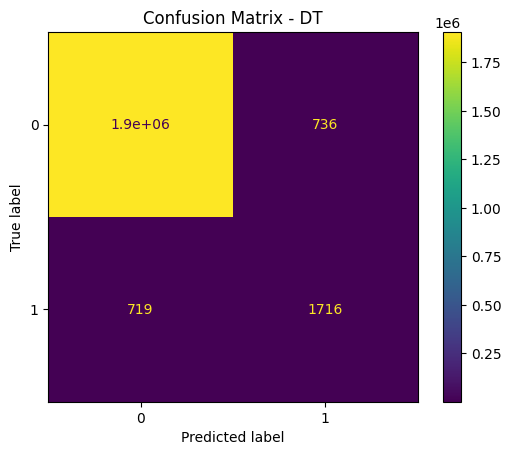

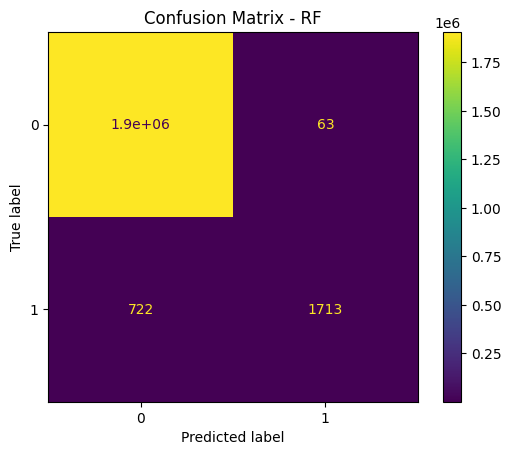

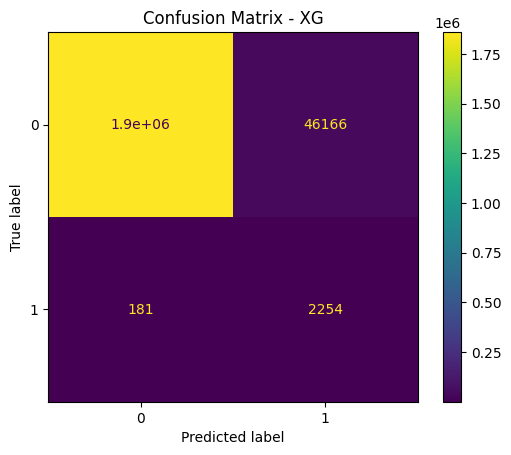

In [39]:
# visualising confusion matrix - DT


disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_dt)
disp.plot()
plt.title('Confusion Matrix - DT')
plt.show()

# visualising confusion matrix - RF
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_rf)
disp.plot()
plt.title('Confusion Matrix - RF')
plt.show()


# visualising confusion matrix - XG
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_xg)
disp.plot()
plt.title('Confusion Matrix - XG')
plt.show()

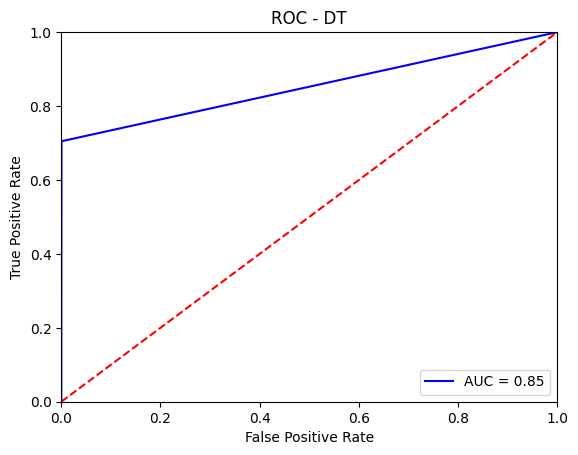

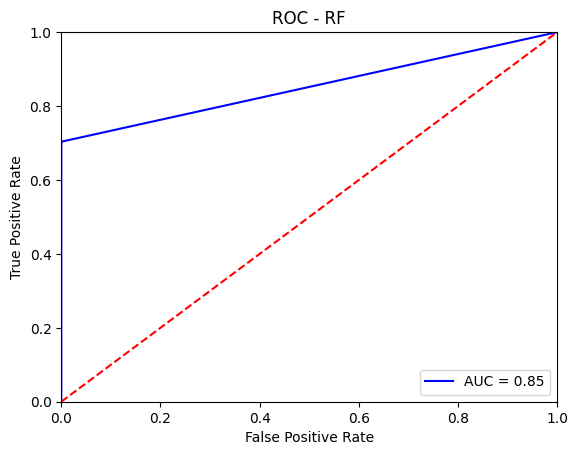

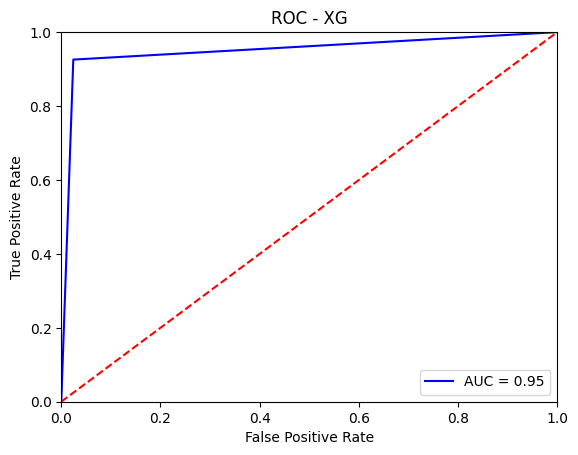

In [40]:
# AUC ROC - DT
# calculate the fpr and tpr for all thresholds of the classification

fpr, tpr, threshold = metrics.roc_curve(Y_test, Y_pred_dt)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC - DT')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# AUC ROC - RF
# calculate the fpr and tpr for all thresholds of the classification

fpr, tpr, threshold = metrics.roc_curve(Y_test, Y_pred_rf)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC - RF')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


# AUC ROC - XG
# calculate the fpr and tpr for all thresholds of the classification

fpr, tpr, threshold = metrics.roc_curve(Y_test, Y_pred_xg)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC - XG')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

THE AUC for both Decision Tree and Random Forest is similar but not to XGBoost Classifier.

#Conclusion

We can see that the accuracy of the random forest and the decision tree is equal, but the precision of the Random Forest is greater. The XGBoost Classifier outperforms both in accuracy but falls short in precision. Precision is essential in a fraud detection model because, rather than correctly predicting normal transactions, we want fraudulent transactions to be correctly predicted while legitimate transactions are ignored. If either of the two reasons is not met, we may catch the innocent while leaving the culprit.This is also one of the reasons why Random Forest and Decision Tree are preferred over other ML and DL algorithms and techniques in precision-focused applications.

I also chose this model because of the highly unbalanced dataset (Legit: Fraud:: 99.87:0.13). Because Decision Tree makes boolean decisions, Random Forest generates multiple decision trees, making it easier (though time-consuming) for the model to understand the data in a simpler way.


What are the key factors that predict fraudulent customer?

1. Is the source of the request secure?
2. Is the name of the organisation asking for money legitimate or not?
3. Vendor transaction history.

What kind of prevention should be adopted while company update its infrastructure?

1.   Only use smart vertified apps.

2.   Search through secure websites.

3. Use encrypted internet connections (VPN).

4. Maintain the security of your smartphone and laptop.

5. Do not respond to unsolicited phone calls, SMS messages, or e-mails.

6. If you believe you have been duped or your security has been compromised, contact your bank immediately.List item


Assuming these actions have been implemented, how would you determine if they work?
1. The bank should send E-statements.
2. Customers should monitor their account activity.
3. Keep a record of your payments at all times.